# Generating Explanatory Images for the Tolkie project

This page describes the learnings from generating images for concepts for the Tolkie project. 

## Process

We have experimented with various ways to aquire images. First, we have connected to an existing (Google) API to download images of concepts. The results were unsatisfying, so we changed the approacht to creating images with the generative AI solution Stabe Diffusion. 

### Initial approach: static prompts
First, we have created static prompts to generate images. In order to run the code on this page, you need a key for the Stable Diffusion API. You can find details here https://platform.stability.ai/docs/getting-started/credits-and-billing . This first code fragment creates a general function for calling the stability_sdk.

In [11]:
import io
import warnings

from PIL import Image
from stability_sdk import client

import stability_sdk.interfaces.gooseai.generation.generation_pb2 as generation

print("Please enter API key...")
STABILITY_KEY = input("Enter the stability key: ")

def generate_image(prompt: str) -> Image:
    stability_api = client.StabilityInference(
        key=STABILITY_KEY,  # API Key reference.
        verbose=True,  # Print debug messages.
        engine="stable-diffusion-xl-1024-v1-0",  # Set the engine to use for generation.
    )

    # Set up our initial generation parameters.
    answers = stability_api.generate(
        prompt=prompt,
        steps=50,  # Amount of inference steps performed on image generation. Defaults to 30.
        cfg_scale=8.0,  # Influences how strongly your generation is guided to match your prompt.
        width=1024,  # Generation width, defaults to 512 if not included.
        height=1024,  # Generation height, defaults to 512 if not included.
        samples=1,  # Number of images to generate, defaults to 1 if not included.
        sampler=generation.SAMPLER_K_DPMPP_2M  # Choose which sampler we want to denoise our generation with.
    )

    for resp in answers:
        for artifact in resp.artifacts:
            if artifact.finish_reason == generation.FILTER:
                warnings.warn(
                    "Your request activated the API's safety filters and could not be processed."
                    "Please modify the prompt and try again."
                )
            if artifact.type == generation.ARTIFACT_IMAGE:
                image = Image.open(io.BytesIO(artifact.binary))
                return image

    return None

print("Initialized.")


Please enter API key...
Initialized.


### Static prompts
Next, we used different kinds of static prompts to experiment with generating images. In this example, the word "bank" is used:

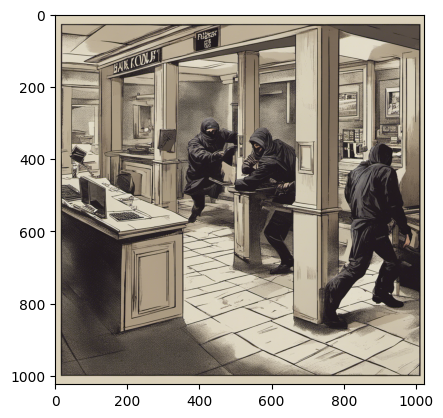

In [12]:
import matplotlib.pyplot as plt

def create_static_image(prompt: str):
    image = generate_image(prompt=prompt)
    if image:
        plt.imshow(image)

word = "bank"
text = "the robbers robbed the bank and ran away with the money"
prompt = f"{word} in the context of '{text}'"

create_static_image(prompt=prompt)


Sometimes this lead to good results. However, with some more conceptual words this approach was insufficient:

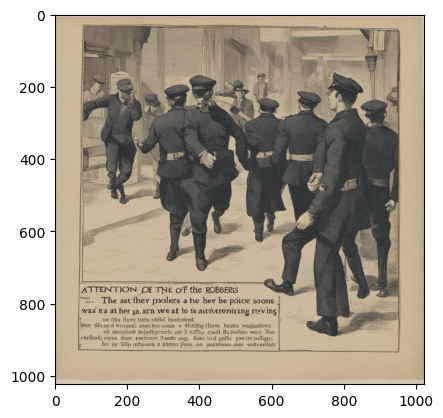

In [13]:
word = "attention"
text = "the attention of the robbers was at the police as they were assumed to be arriving soon"

prompt = f"{word} in the context of '{text}'"

create_static_image(prompt=prompt)


### Dynamic generation of prompts for Stable Diffusion
To cope with the problems above, the next approach was to create the images in a 2-way step by first asking an LLM (GPT3) to generate the right prompts.

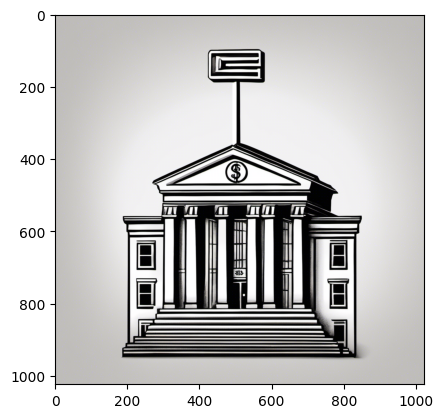

In [14]:
import openai
import traceback

OPENAI_KEY = input("Enter the OpenAI key: ")
openai.api_key = OPENAI_KEY

def call_openai_api(prompt_text: str, max_tokens: int = 50) -> str:
    try:
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt_text}],
            temperature=0,
            max_tokens=max_tokens,
            n=1,
        )

        return response.choices[0]["message"]["content"].strip().strip('"').strip("!")

    except Exception as e:
        print(prompt_text)
        print(e)
        traceback.print_exc()
        return None

    
def create_prompt_for_image_generation(word: str, context: str) -> str:
    prompt_text = f"""
        ### **Instructions**
        1. **Translate** the word _X_ using context _Y_ to English, producing _Z_.
        2. **Categorize** _Z_ into 'Physical Objects', 'Tangible Concepts', or 'Symbolic Concepts', producing _C_.
        3. **Provide a Visual Guide** based on _Y_ for _Z_, producing _D_.
        4. **Combine** _C_ and _D_ into a final **Illustration Directive**.

        ### **Rules for Guidance D**:

        - **Absolutely NO**: words, punctuation, question marks, numbers, dice pips, speech bubbles, thought bubbles, or visual effects.
        - Imagery should avoid being too literal where forbidden elements might be tempting to use.
        - Must be clear and easily understood.

        ### **Output Formula**:

        - If _C_ is "Physical Objects": "A clipart vector drawing of _D_ to visualize [Z]. White background."
        - If _C_ is "Tangible Concepts": "A clipart vector drawing of _D_ to represent the concept of [Z]. White background."
        - If _C_ is "Symbolic Concepts": "A clipart vector drawing of _D_ to symbolize [Z]. White background."

        ### **Examples**:

        **Input**: _X_ = "Huurachterstand", _Y_ = "Een huurachterstand betekent dat iemand de huur van zijn huis niet op tijd heeft betaald en nu geld schuldig is aan de verhuurder."

        **Output**: "A clipart vector drawing of a house with a clock and money to visually represent the concept of [rent arrears]. White background."

        **Input**: _X_ = "Geheugen", _Y_ = "Het vermogen om vroegere ervaringen of kennis te herinneren."

        **Output**: "A clipart vector drawing of a brain intertwined with a faded calendar page to symbolize [memory]. White background."

        **Input**: _X_ = "Communicatie", _Y_ = "Het proces van informatie overbrengen tussen individuen."

        **Output**: "A clipart vector drawing of two people facing each other with abstract sound waves between them to symbolize [communication]. White background."

        ### **IMPORTANT**:
        Only provide the final output without additional explanations, the word 'output', or process breakdown.

        ### **Input**:
        The **Input** is: _X_ = "{word}", _Y_ = "{context}"
    """

    return call_openai_api(prompt_text, max_tokens=1000)

word = "bank"
text = "the robbers robbed the bank and ran away with the money"

prompt = create_prompt_for_image_generation(word, text)

create_static_image(prompt=prompt)



And again for the case of 'attention':

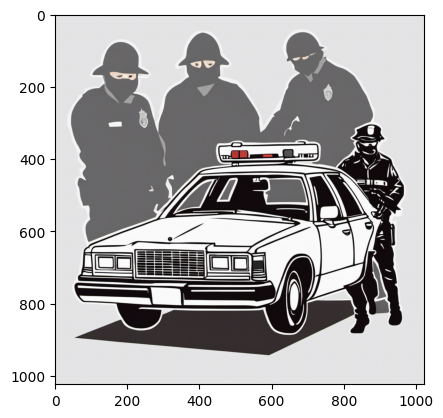

In [15]:
word = "attention"
text = "the attention of the robbers was at the police as they were assumed to be arriving soon"

prompt = create_prompt_for_image_generation(word, text)

create_static_image(prompt=prompt)